In [390]:
import pandas as pd
import numpy as np
from scipy import sparse
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sts
from copy import copy

from IPython.display import Image
import pickle
from datetime import datetime, timedelta
import json
import gc
import re
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# 1. Downloading...
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года; 
в тестовый — турниры с dateStart из 2020 года.

In [391]:
with open("chgk/results.pkl", "rb") as handler:
    results = pickle.load(handler)

In [392]:
with open("chgk/tournaments.pkl", "rb") as handler:
    tournaments = pickle.load(handler)
    tournaments_df = pd.DataFrame(tournaments)
    
tdf = tournaments_df.transpose()
tdf.dateStart = pd.to_datetime(tdf.dateStart)
tdf.sample(5)

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
6161,6161,Студенческий чемпионат Тюменской области,2019-12-22 12:30:00+03:00,2019-12-22T18:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 102719, 'name': 'Олег', 'patronymic': ...",None,"{'1': 15, '2': 15, '3': 15}"
361,361,Чемпионат Грузии,2008-05-31 00:00:00+04:00,2008-06-01T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/7,[],None,None
1445,1445,Открытый чемпионат Курска,2000-01-08 00:00:00+03:00,2000-01-09T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/5,[],None,None
5453,5453,Кубок губернатора Иркутской области,2019-04-06 07:00:00+03:00,2019-04-07T14:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/52,"[{'id': 39218, 'name': 'Владислав', 'patronymi...",None,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, ..."
4255,4255,Чемпионат Великобритании,2017-04-09 14:00:00+03:00,2017-04-09T18:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/50,"[{'id': 21235, 'name': 'Ирина', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12, '4': 12}"


In [393]:
players_dictionary = dict()
with open("chgk\players.pkl", "rb") as handler:
    players = pickle.load(handler)
    players_dictionary = players
    players_df = pd.DataFrame(players)
    for player in players:
        players_dictionary[player] = players[player]["surname"] + " " + players[player]["name"]
    
pdf = players_df.transpose()
pdf.sample(5)

,id,name,patronymic,surname
20210,20210,Павел,,Матвеев
190239,190239,Николай,Николаевич,Козубенко
144313,144313,Андрей,Александрович,Крутов
168509,168509,Елена,Валерьевна,Фон Клигманн
211471,211471,Павел,Николаевич,Аксёнов


We preproccess the data about the tournaments in train part

In [394]:
train_start_date = pd.to_datetime("2019/01/01 00:00:00", utc=True)
train_end_date = pd.to_datetime("2019/12/31 23:59:59", utc=True)
train_tournaments = tdf[tdf.dateStart.between(train_start_date, train_end_date)]
train = []

for i in train_tournaments.id:
    tournament = results.get(i, -1)
    # We drop tournaments on which we have no information
    if tournament == -1:
        continue
    
    tournament_dict = dict()
    tournament_dict["id"] = i
    tournament_dict["teams"] = []
    
    for team in tournament:
        mask = team.get("mask", "")
        # We get rid of teams with no or invalid masks
        if not mask or re.sub("[0-1]+", "", mask):
            continue
                  
        team_dict = dict()
        team_dict["id"] = team["team"]["id"]
        team_dict["mask"] = list(int(i) for i in mask)
        team_dict["members"] = []
        
        for member in team["teamMembers"]:
            team_dict["members"].append(int(member["player"]["id"]))
    
        tournament_dict["teams"].append(team_dict)
    # If we add no teams lets move further
    if not tournament_dict["teams"]:
        continue
    train.append(tournament_dict)
    
# We save the preproccessed data to spare the time
with open("train.json", "w") as file:
    json.dump(train, file)

And then repeat the procedure for the test part

In [395]:
test_start_date = pd.to_datetime("2020/01/01 00:00:00", utc=True)
test_end_date = pd.to_datetime("2020/12/31 23:59:59", utc=True)
test_tournaments = tdf[tdf.dateStart.between(test_start_date, test_end_date)]
test = []

for i in test_tournaments.id:
    tournament = results.get(i, -1)
    # We drop tournaments on which we have no information
    if tournament == -1:
        continue
    
    tournament_dict = dict()
    tournament_dict["id"] = i
    tournament_dict["teams"] = []
    
    for team in tournament:
        mask = team.get("mask", "")
        # We get rid of teams with no or invalid masks
        if not mask or re.sub("[0-1]+", "", mask):
            continue
                
        team_dict = dict()
        team_dict["id"] = team["team"]["id"]
        team_dict["mask"] = list(int(i) for i in mask)
        team_dict["members"] = []
        
        for member in team["teamMembers"]:
            team_dict["members"].append(int(member["player"]["id"]))
    
        tournament_dict["teams"].append(team_dict)
    # If we add no teams lets move further
    if not tournament_dict["teams"]:
        continue
    test.append(tournament_dict)
    
# We save the preproccessed data to spare the time
with open("test.json", "w") as file:
    json.dump(test, file)

Now if something goes wrong we are ready)

In [396]:
with open("train.json", "r") as file:
    tournaments_train = json.load(file)
    
with open("test.json", "r") as file:
    tournaments_test = json.load(file)

# ... and preproccess it

In [397]:
total_bingos = 0
total_misses = 0
questions = []
avg_bingos_pro_tour = []
player_right_ans = defaultdict(list)
player_ans = defaultdict(list)
player_tournaments = defaultdict(list)
player_teams = defaultdict(list)
players_dict = Counter()

for tournament in train:
    for team in tournament["teams"]:
        players = team["members"]
        bingos_pro_tour = sum(team["mask"])
        questions_pro_tour = len(team["mask"])
        total_bingos += questions_pro_tour - bingos_pro_tour
        avg_bingos_pro_tour.append(bingos_pro_tour / questions_pro_tour)
        questions.append(questions_pro_tour)
        for player in players:
            players_dict[player] += 1
            player_right_ans[player].append(bingos_pro_tour)
            player_ans[player].append(questions_pro_tour)
            player_tournaments[player].append(tournament["id"])
            player_teams[player].append(team["id"])

In [400]:
new_players_dict = {player: idx for idx, player in enumerate(players_dict)}
new_dict_players = {idx: player for idx, player in enumerate(players_dict)}

In [401]:
n_players = len(players_dict)
n_questions = sum(questions)

One player has even taken part at 189 tournaments
Average number of questions in a tour: 43. Maximal number of questions 500.


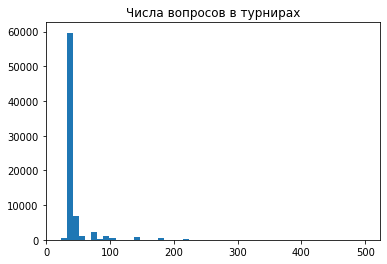

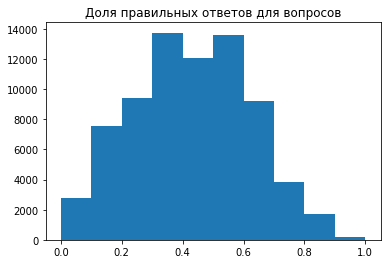

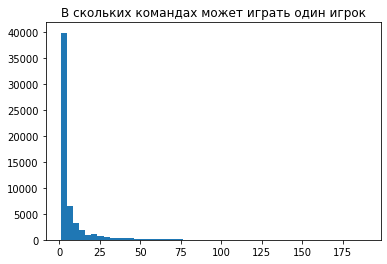

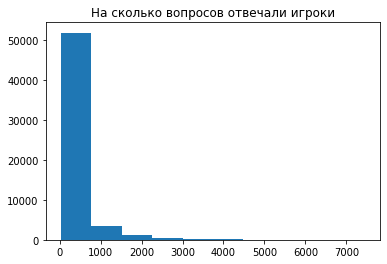

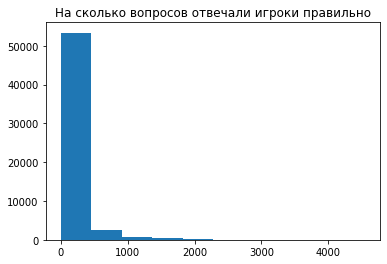

In [402]:
print(f"One player has even taken part at {max(players_dict.values())} tournaments")
print(f"Average number of questions in a tour: {np.mean(questions):.0f}. Maximal number of questions {np.max(questions)}.")

plt.hist(questions, bins=50)
plt.title("Числа вопросов в турнирах")
plt.show();

plt.hist(avg_bingos_pro_tour, bins=10)
plt.title("Доля правильных ответов для вопросов")
plt.show();

plt.hist(list(len(teams) for teams in player_teams.values()), bins=50)
plt.title("В скольких командах может играть один игрок")
plt.show();

plt.hist(list(sum(ans) for ans in player_ans.values()),bins=10);
plt.title("На сколько вопросов отвечали игроки")
plt.show();

plt.hist(list(sum(q) for q in player_right_ans.values()),bins=10);
plt.title("На сколько вопросов отвечали игроки правильно")
plt.show();

# 2. Baseline model

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [403]:
y = []
questions_asked = 0
row_idx = 0
column_idx = 0
idx = []
team_ids = []
questions_idx = []

for tournament in train:
    for team in tournament["teams"]:
        players = team["members"]
        mask = team["mask"]
        for i, question in enumerate(mask):
            questions_idx += [len(new_players_dict) + column_idx for _ in range(len(players))]
            team_ids += [team["id"] for _ in range(len(players))]
            for j, player in enumerate(players):
                idx.append((row_idx, new_players_dict[player]))
                idx.append((row_idx, len(new_players_dict) + column_idx))
                row_idx += 1
                y.append(1 if question else 0)
            column_idx += 1    
        questions_asked = len(y)

len(y), questions_asked, n_players + column_idx

(17392830, 17392830, 3263732)

In [405]:
X = sparse.lil_matrix((len(y), n_players + column_idx))

In [407]:
len(questions_idx), len(team_ids)

(17392830, 17392830)

In [408]:
for i, j in idx:
    X[i, j] = 1

In [409]:
y = np.array(y)
dim0, dim1 = X.shape

In [410]:
lr = LogisticRegression(tol=1e-1, solver="saga", C=10)
lr.fit(X, y)

LogisticRegression(C=10, solver='saga', tol=0.1)

In [411]:
QUESTION_LIMIT = 1000

question_rating = lr.coef_[0][n_players:]
rating = lr.coef_[0][:n_players]
rating_list = []
for idx, player in enumerate(new_players_dict):
    if sum(player_ans[player]) < QUESTION_LIMIT:
        continue
    item = {
        "score": rating[idx],
        "id": player,
        "name": players_dictionary[player],
        "questions_count": sum(player_ans[player]),
    }
    rating_list.append(item)
    
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

In [412]:
df_rating = pd.DataFrame(sorted_rating)[:50]
df_rating.head(50)

,score,id,name,questions_count
0,3.406273,27403,Руссо Максим,2075
1,3.223976,4270,Брутер Александра,2555
2,3.130394,28751,Семушин Иван,3386
3,3.057971,27822,Савченков Михаил,3107
4,3.016116,30270,Спешков Сергей,3440
5,2.892332,30152,Сорожкин Артём,4375
6,2.767602,87637,Саксонов Антон,1179
7,2.752638,34846,Чернин Антон,1751
8,2.752197,16332,Крапиль Николай,1400
9,2.718039,56647,Горелова Наталья,2021


After limiting the minimal number of questions answered by a player to 1000 we can notice by manually comparing the achieved list of top 50 players with the same number of players on the scoresheet (site "https://rating.chgk.info/players.php") that quite a number of players enter both lists.

# 3. Predictions quality
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

In [413]:
tournaments_test = []
tournaments_rating_true = []

for tournament in test:
    teams_test = []
    teams_rating = []
    for team in tournament["teams"]:
  
        memebers = [member for member in team["members"] if member in member_to_idx.keys()]
        team_test = copy(team)
        team_test["members"] = memebers
        
        if len(memebers) > 0:
            teams_test.append(team_test)
            team_answers = list(map(int, team["mask"]))
            team_score = sum(team_answers)
            teams_rating.append(team_score)
     
    if len(teams_test) > 1:
        tournament_test = copy(tournament)
        tournament_test["teams"] = teams_test
        tournaments_test.append(tournament_test)
        tournaments_rating_true.append(teams_rating)

In [414]:
def predict_tournaments(model, tournaments, member_to_idx):
    tournaments_rating_pred = []
    for torunament in tqdm(tournaments, position=0, leave=False):
        tournament_questions_count = len(tournament["teams"][0]["mask"])
        preds = []
        for team in torunament["teams"]:
            memeber_idxs = [member_to_idx[member] for member in team["members"]]
            members_count = len(memeber_idxs)
 
            X = sparse.lil_matrix((members_count, dim1), dtype=int)
            X[range(len(memeber_idxs)), memeber_idxs] = 1
        
            fail_probas = model.predict_proba(X)[:, 0]
            team_proba = 1 - fail_probas.prod() 
            preds.append(team_proba)

        tournaments_rating_pred.append(preds)
    return tournaments_rating_pred


def print_correlations(tournaments_rating_true, tournaments_rating_pred):
    spearmanr_corrs = []
    kendall_corrs = []
    for i in range(len(tournaments_rating_true)):
        spearman = sts.spearmanr(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        kendall = sts.kendalltau(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        spearmanr_corrs.append(spearman)
        kendall_corrs.append(kendall)

    print(f"Spearman correlation: {np.mean(spearmanr_corrs)}")
    print(f"Kendall correlation: {np.mean(kendall_corrs)}")

In [415]:
tournaments_rating_pred = predict_tournaments(
    model=lr, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
)
print_correlations(tournaments_rating_true, tournaments_rating_pred)

Spearman correlation: 0.7170099109775323
Kendall correlation: 0.5612930588010243


# 4. Variations
Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
разработайте EM-схему для обучения этой модели, реализуйте её в коде;
обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

In [416]:
# We would start from this point
lr_initial = LogisticRegression(tol=1e-1, solver='saga', penalty='none')
lr_initial.fit(X, y)

LogisticRegression(penalty='none', solver='saga', tol=0.1)

In [417]:
class ProbabilityEstimator:
    def __init__(self, init_classifier=None):
        if init_classifier:
            self.w = np.hstack((init_classifier.intercept_, init_classifier.coef_[0]))
        else:
            self.w = None
        
    def fit(self, X, y, max_iters=100000, lr=10, batch_size=1000, tol=0.0000001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')
        if self.w is None:
            self.w = np.random.normal(size=X.shape[1])
            
        losses = []
        prev_mean_loss = np.inf
        
        data_len = X.shape[0]
        
        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = sigmoid(X_batch.dot(self.w))
            losses.append(self.log_loss(y_batch, preds))
            if (i + 1) % 1000 == 0:
                new_mean_loss = np.mean(losses)
                if (prev_mean_loss - new_mean_loss) < tol:
                    print(f'Fitted. Mean NLL: {new_mean_loss}', flush=True)
                    break                    
                losses = []
                prev_mean_loss = new_mean_loss

            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
            self.w -= lr * grad 
    
    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = sigmoid(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))
    
    @staticmethod
    def log_loss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [418]:
estimator = ProbabilityEstimator(init_classifier=lr_initial)

tournaments_rating_pred = predict_tournaments(
    model=estimator, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
)
print_correlations(tournaments_rating_true, tournaments_rating_pred)

for _ in range(5):
    
    # E-step
    preds = estimator.predict_proba(X)
    
    # The probability of the correct answer by a player dependant on certain team
    df_team = pd.DataFrame({"team": team_ids,
                            "question": questions_idx,
                            "fail_pred": preds[:, 0],
                            "success_pred": preds[:, 1]})
    df_team_pis = df_team.groupby(["team", "question"]).agg({"fail_pred": "prod"}).reset_index()
    df_team_pis["team_success_pred"] = 1 - df_team_pis["fail_pred"]
    df_team_pis.drop(columns=["fail_pred"], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', "question"],  right_on=["team", "question"])
    z = (df_team["success_pred"] / df_team["team_success_pred"]).clip(0, 1)
    
    # The question unanswered by a team is unanswered by all team's members
    nonzero_idx = np.zeros(len(y))
    nonzero_idx[np.flatnonzero(y)] = 1
    z *= nonzero_idx 
    
    # M-step
    estimator.fit(X, z, lr=20)

    tournaments_rating_pred = predict_tournaments(
        model=estimator, 
        tournaments=tournaments_test,
        member_to_idx=member_to_idx, 
    )
    print_correlations(tournaments_rating_true, tournaments_rating_pred)

Spearman correlation: 0.7196896385578575
Kendall correlation: 0.5642892829705364
Fitted. Mean NLL: 0.07467995080675521


Spearman correlation: 0.7205026384079561
Kendall correlation: 0.5647055804638649
Fitted. Mean NLL: 0.09735712343791339


Spearman correlation: 0.7211740804051072
Kendall correlation: 0.5657729206659572
Fitted. Mean NLL: 0.11230087672976723


Spearman correlation: 0.7208572387458169
Kendall correlation: 0.5658244493277425
Fitted. Mean NLL: 0.12368958312770244


Spearman correlation: 0.7218770921383094
Kendall correlation: 0.5666643384078991
Fitted. Mean NLL: 0.13546488706941917


Spearman correlation: 0.7218728746720438
Kendall correlation: 0.5665045551486885


# 5. Tournaments difficulty
А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)?

In [419]:
tournament_rating = dict()
question_rating = question_rating
question_to_tour = dict()
questions_count = 0

for tournament in train:
    tour_questions_count = len(tournament["teams"][0]["mask"])
    start_index, end_index = questions_count, questions_count + tour_questions_count
    tournament_rating[tournament["id"]] = np.sum(question_rating[start_index: end_index])
    for q in range(tour_questions_count):
        question_to_tour[questions_count + q] = {
            "tournament_id": tournament["id"],
            "tournament_name": tournaments[tournament["id"]]["name"],
            "question_num": q + 1,
        }
    questions_count += tour_questions_count
    
tournament_rating = sorted(tournament_rating.items(), key=lambda x: x[1])
df_tournament_rating = pd.DataFrame(tournament_rating, columns=["id", "rating"]).drop(columns=["rating"])
df_tournament_rating["name"] = df_tournament_rating["id"].apply(lambda x: tournaments[x]["name"])

In [420]:
# The top 10 hardest tournaments
df_tournament_rating[-10:]

,id,name
608,5488,Чемпионат Беларуси среди школьников
609,5533,Саратов
610,5498,Первенство Сибири
611,5490,Чемпионат США
612,5660,Первая лига ЧТ
613,5592,Студенческая лига ЧТ
614,5564,Молодёжный чемпионат Нижегородской области
615,5554,Гран-при Славянки. Общий зачёт
616,5827,Шестой киевский марафон. Асинхрон
617,5553,Славянка без раздаток. Общий зачёт


In [421]:
# The top 10 easiest tournaments
df_tournament_rating[:10]

,id,name
0,5484,Открытый чемпионат Польши
1,5475,Открытый кубок Дальнего Востока
2,5472,Открытый Кубок Зеленограда
3,5464,Зимние игры
4,5453,Кубок губернатора Иркутской области
5,5473,Ревельская весна
6,6254,Школьная лига
7,5443,Vilnius Open
8,6255,ОВСЧ
9,5462,Синхронный Кубок Ростова - общий зачёт
